In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import torch
import torchvision
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from torch import nn
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [80]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((32, 32), interpolation=v2.InterpolationMode.NEAREST),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

trainset = torchvision.datasets.MNIST(root="data", download=True, train=True, transform=transform)

In [81]:
image, label = trainset[44]

In [82]:
image.shape

torch.Size([1, 32, 32])

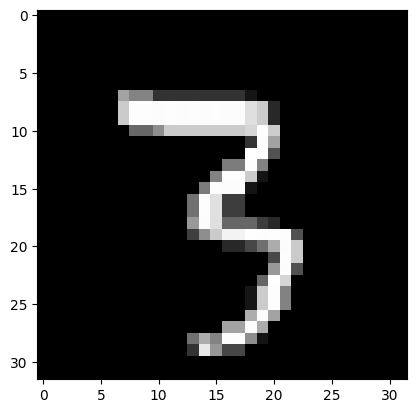

In [83]:
plt.imshow(image[0], cmap='grey')
plt.show()

## Own vae

In [55]:
%load_ext autoreload
%autoreload 2

In [56]:
import torch
import torch.nn as nn
from torchinfo import summary

In [58]:
from models.vae import VAE, VAEConfig

In [70]:
config = VAEConfig(
    hid_channels=16,
    downsample_factors=(2, 2, 2),
    latent_channels=4,
)
vae = VAE(config)
vae = vae.to(device)

In [71]:
summary(vae, (1, 1, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
VAE                                           [1, 1, 256, 256]          --
├─Encoder: 1-1                                [1, 4, 32, 32]            580
│    └─Sequential: 2-1                        [1, 16, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 16, 256, 256]         160
│    │    └─ResBlock: 3-2                     [1, 16, 256, 256]         6,960
│    └─Sequential: 2-2                        [1, 16, 32, 32]           --
│    │    └─Sequential: 3-3                   [1, 16, 128, 128]         9,264
│    │    └─Sequential: 3-4                   [1, 16, 64, 64]           9,264
│    │    └─Sequential: 3-5                   [1, 16, 32, 32]           9,264
│    └─Conv2d: 2-3                            [1, 4, 32, 32]            580
│    └─Conv2d: 2-4                            [1, 4, 32, 32]            (recursive)
├─Decoder: 1-2                                [1, 1, 256, 256]         

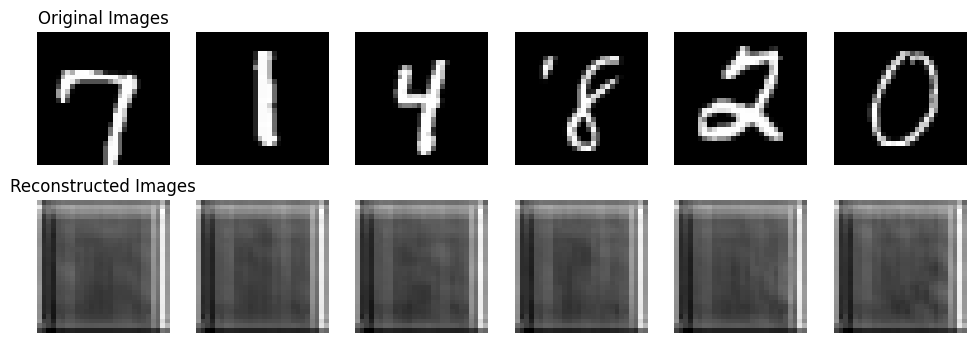

In [13]:
def vae_reconstruction(model, n_samples=5):
    dataloader = DataLoader(trainset, batch_size=n_samples, shuffle=True)
    images, _ = next(iter(dataloader))
    images = images.to(device)

    model.eval()  
    with torch.no_grad():
        reconstructed_images, _, _ = model(images)

    # Display original and reconstructed images
    fig, axes = plt.subplots(2, n_samples, figsize=(2 * n_samples, 4))
    for i in range(n_samples):
        axes[0, i].imshow(images[i].squeeze().detach().cpu().numpy(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed_images[i].squeeze().detach().cpu().numpy(), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")
    plt.show()

vae_reconstruction(vae, 6)

## Training

In [14]:
def kl_loss(mu, logvar):
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

mse_loss = nn.MSELoss()

In [15]:
num_epochs = 10
batch_size = 128 
lr = 3e-4 # Karpathy constant

train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

vae = VAE().to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

In [16]:
from tqdm.notebook import tqdm

In [ ]:
for epoch in range(num_epochs):
    vae.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (x, y) in loop:
        x = x.to(device)
        x_rec, mu, logvar = vae(x)

        loss = mse_loss(x_rec, x) + kl_loss(mu, logvar)

        optim.zero_grad()
        loss.backward()
        optim.step()

        loop.set_postfix(loss=loss.item())
        loop.update()
    loop.close()


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [18]:
torch.save(vae.state_dict(), "checkpoints/vae.ckpt")

In [19]:
testset = torchvision.datasets.MNIST(root="data", download=True, train=False, transform=transform)

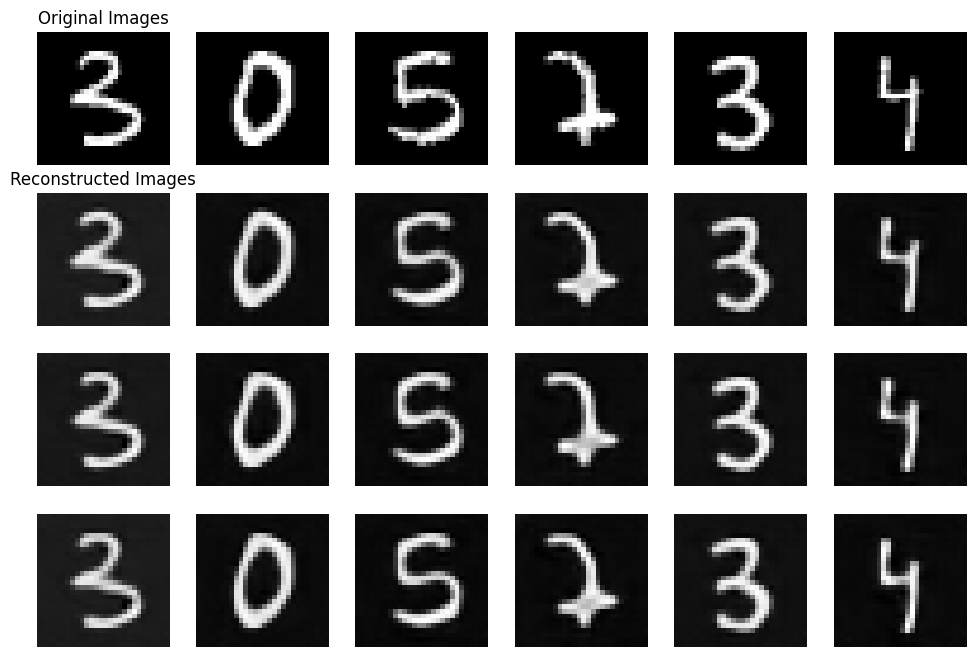

In [31]:
def vae_reconstruction(model, n_samples=5):
    dataloader = DataLoader(testset, batch_size=n_samples, shuffle=True)
    images, _ = next(iter(dataloader))
    images = images.to(device)

    n_recs = 3
    reconstructions = []

    model.eval()  
    with torch.no_grad():
        for i in range(n_recs):
            reconstructed_images, _, _ = model(images)
            reconstructions.append(reconstructed_images)

    # Display original and reconstructed images
    fig, axes = plt.subplots(1 + n_recs, n_samples, figsize=(2 * n_samples, 2 + 2 * n_recs))
    for i in range(n_samples):
        axes[0, i].imshow(images[i].squeeze().detach().cpu().numpy(), cmap="gray")
        axes[0, i].axis("off")

        for i_rec in range(n_recs):
            axes[i_rec + 1, i].imshow(reconstructions[i_rec][i].squeeze().detach().cpu().numpy(), cmap="gray")
            axes[i_rec + 1, i].axis("off")
    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")
    plt.show()

vae_reconstruction(vae, 6)

In [21]:
with torch.inference_mode():
    mu, logvar = vae.encode(image.to(device))
    latent = vae.sample(mu, logvar)

In [22]:
latent.shape

torch.Size([1, 7, 7])

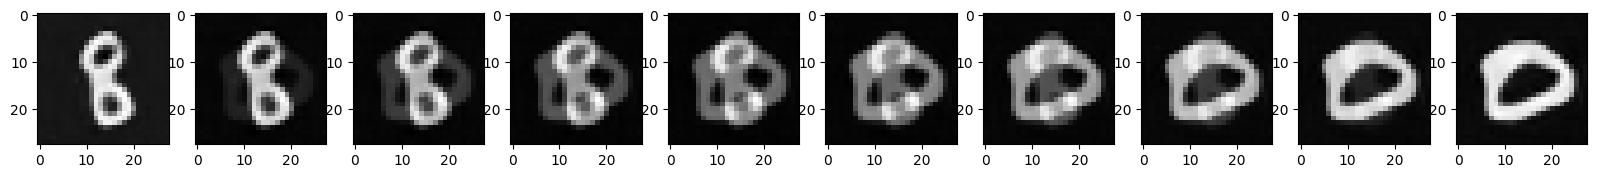

In [37]:
dataloader = DataLoader(testset, batch_size=5, shuffle=True)
images, _ = next(iter(dataloader))
images = images.to(device)

vae.eval()  
with torch.no_grad():
    reconstructed_images, _, _ = vae(images)
reconstructed_images = reconstructed_images.detach().cpu().numpy()

n_steps = 10
fig, axes = plt.subplots(1, n_steps, figsize=(2 * n_steps, 2))
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    axes[i].imshow(((1 - alpha) * reconstructed_images[0] + alpha * reconstructed_images[1])[0], cmap="grey")

## Notes

Виходить vae з доволі великою розмірністю латентного простору, тому воно тут більше номінально

Генеративна задача для FM складніша за рахунок цього, але сам підхід корисно відточити для переходу на більші розміри зображень